In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointShiftOperatorModel as Model #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [3]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([-2,0,0],[10,10,10])# corners of the grid - in units of space
boundary2 = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
resolution1 = [60,30,30] # grid size for time, x and y
resolution2 = [50,30,30] # grid size for time, x and y

m = Model(boundary=boundary2,resolution=resolution2,kernel=k,noiseSD=noiseSD,N_feat=N_feat,sensormodel=sensors) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [16]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations()#addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

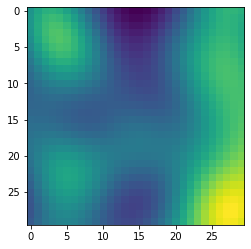

In [17]:
plt.imshow(concTrain[10])

In [18]:
N_feat =2000 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = Model(resolution=resolution2,boundary=boundary2,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concInfer = mPDE.computeConcentration(sourceInfer)

Calculating Adjoints...
47/48 
Calculating Phis...
1999/2000 


In [19]:
np.mean((sourceGT-sourceInfer)**2)

0.47690950649954517

In [20]:
np.mean((concTrain-concInfer)**2)

0.4045210463292394

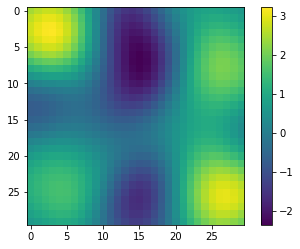

In [21]:
plt.imshow(sourceInfer[4])
plt.colorbar()

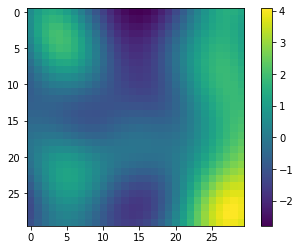

In [22]:
plt.imshow(sourceGT[4])
plt.colorbar()

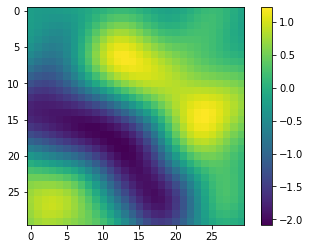

In [23]:
plt.imshow(concInfer[49])
plt.colorbar()

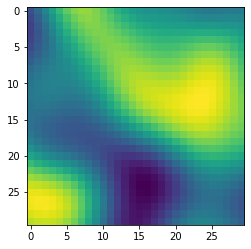

In [24]:
plt.imshow(concTrain[49])

In [25]:
np.std(yTrain)

1.2582244098381636

In [26]:
np.max(yTrain)

2.247346065295194

In [27]:
np.min(yTrain)

-2.6507136587027196